In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
from glob import glob
import zipfile
from tqdm import tqdm
from tensorflow.keras.utils import Sequence

2025-06-16 14:17:39.318189: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750083459.553917     131 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750083459.622894     131 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2025-06-16 14:17:47.502984: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [11]:
def gaussian_kernel_discrete(sigma=15):
    kernel_radius = int(2.5 * sigma)
    size = 2 * kernel_radius + 1
    ax = np.arange(-kernel_radius, kernel_radius + 1)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))
    kernel /= np.sum(kernel)
    return kernel

def generate_density_map(image_shape, points, sigma=15):
    h, w = image_shape
    density_map = np.zeros((h, w), dtype=np.float32)
    kernel = gaussian_kernel_discrete(sigma)
    kH, kW = kernel.shape
    kH2, kW2 = kH // 2, kW // 2

    for point in points:
        x = min(w - 1, max(0, int(point[0])))
        y = min(h - 1, max(0, int(point[1])))

        x1 = max(0, x - kW2)
        x2 = min(w, x + kW2 + 1)
        y1 = max(0, y - kH2)
        y2 = min(h, y + kH2 + 1)

        kx1 = kW2 - (x - x1)
        kx2 = kW2 + (x2 - x)
        ky1 = kH2 - (y - y1)
        ky2 = kH2 + (y2 - y)

        density_map[y1:y2, x1:x2] += kernel[ky1:ky2, kx1:kx2]

    return density_map

def load_points_from_mat(mat_file):
    mat = sio.loadmat(mat_file)
    try:
        points = mat['image_info'][0, 0][0, 0][0]
    except:
        raise ValueError("Check the internal structure of your .mat file.")
    return points

Image: IMG_1.jpg
→ Number of people (points): 234
→ Sum of density map: 210.57



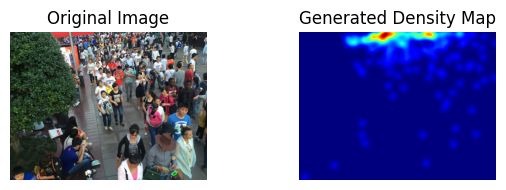

Image: IMG_10.jpg
→ Number of people (points): 230
→ Sum of density map: 207.34



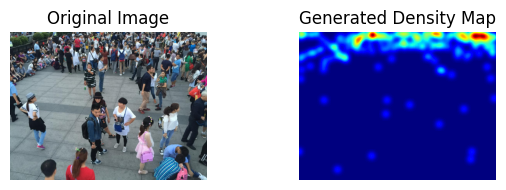

Image: IMG_100.jpg
→ Number of people (points): 206
→ Sum of density map: 203.86



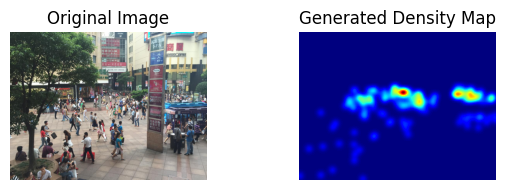

Image: IMG_101.jpg
→ Number of people (points): 83
→ Sum of density map: 80.14



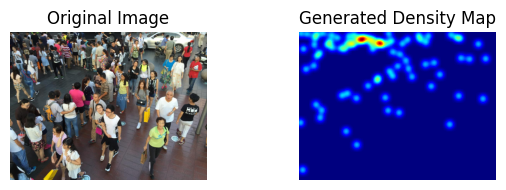

In [ ]:
import cv2
image_dir = '/kaggle/input/crowd-wala-dataset/crowd_wala_dataset/train_data/images'
mat_dir = '/kaggle/input/crowd-wala-dataset/crowd_wala_dataset/train_data/ground_truth'

image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])[:4]

for img_file in image_files:
    img_path = os.path.join(image_dir, img_file)
    mat_path = os.path.join(mat_dir, 'GT_' + img_file.replace('.jpg', '.mat'))

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_shape = img.shape[:2]  # (height, width)

    # Load points and generate density map
    points = load_points_from_mat(mat_path)
    density_map = generate_density_map(img_shape, points, sigma=15)

    print(f"Image: {img_file}")
    print(f"→ Number of people (points): {len(points)}")
    print(f"→ Sum of density map: {density_map.sum():.2f}\n")

    plt.figure(figsize=(6, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(density_map, cmap='jet')
    plt.title('Generated Density Map')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

❌ Extraction failed: Zip file not found: /content/crowd_wala_dataset.zip
Image: IMG_1.jpg
→ Image shape: (768, 1024)
→ Number of people (points): 234
→ Sum of density map: 210.57
→ Max density value: 0.0091
→ Density map shape: (768, 1024)



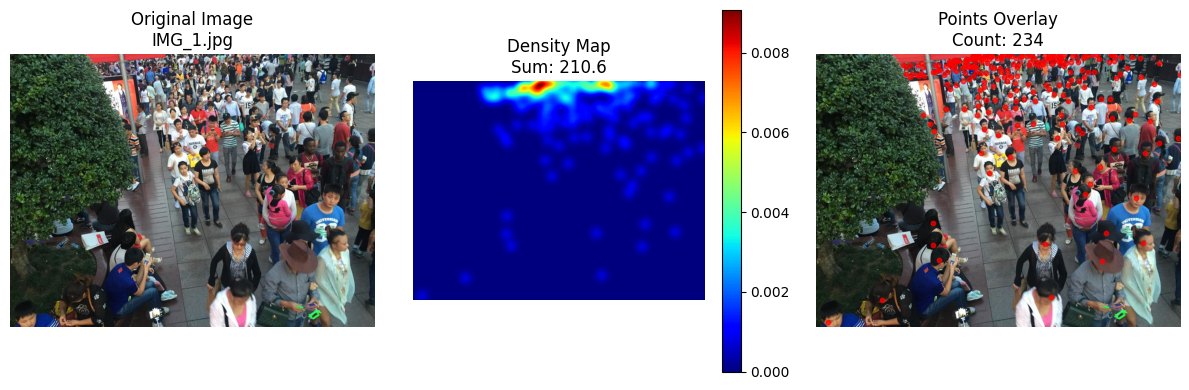

Image: IMG_10.jpg
→ Image shape: (768, 1024)
→ Number of people (points): 230
→ Sum of density map: 207.34
→ Max density value: 0.0052
→ Density map shape: (768, 1024)



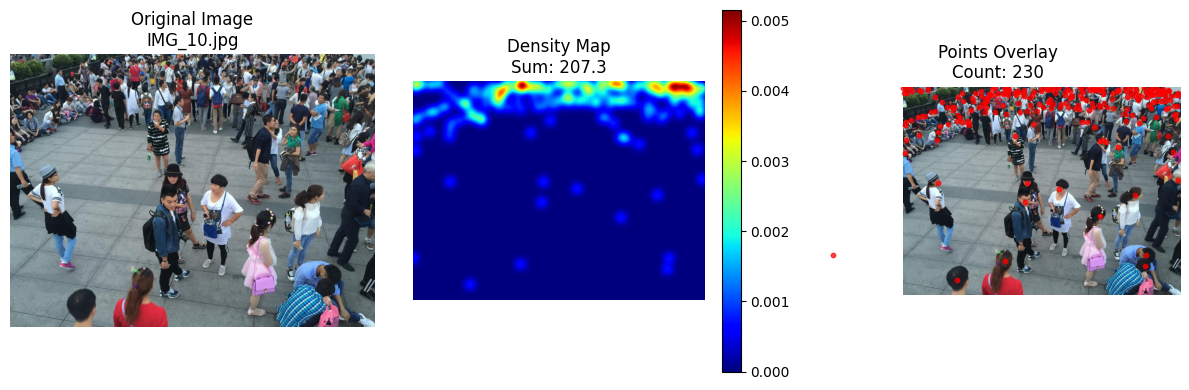

Image: IMG_100.jpg
→ Image shape: (768, 1024)
→ Number of people (points): 206
→ Sum of density map: 203.86
→ Max density value: 0.0078
→ Density map shape: (768, 1024)



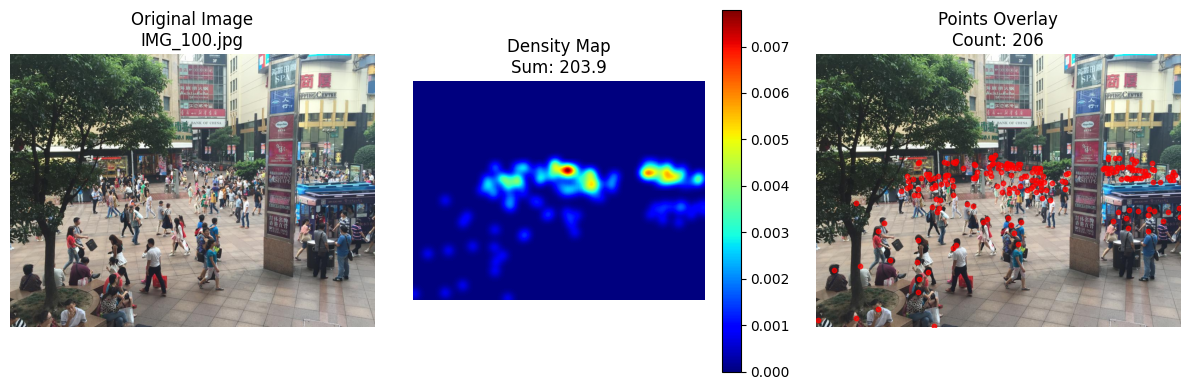

Image: IMG_101.jpg
→ Image shape: (768, 1024)
→ Number of people (points): 83
→ Sum of density map: 80.14
→ Max density value: 0.0024
→ Density map shape: (768, 1024)



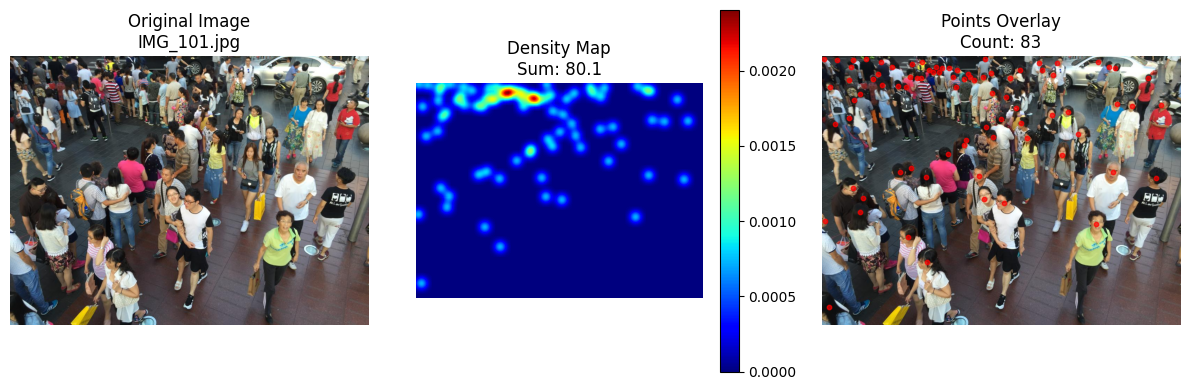

In [ ]:
import os
import zipfile
import numpy as np
import cv2
import scipy.io as sio
import matplotlib.pyplot as plt

def extract_dataset(zip_path, extract_to='/content'):
    if not os.path.exists(zip_path):
        raise FileNotFoundError(f"Zip file not found: {zip_path}")

    os.makedirs(extract_to, exist_ok=True)

    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"Files extracted to: {extract_to}")
    except zipfile.BadZipFile:
        raise ValueError(f"Invalid zip file: {zip_path}")

def gaussian_kernel_discrete(sigma=15):
    kernel_radius = int(2.5 * sigma)
    size = 2 * kernel_radius + 1
    ax = np.arange(-kernel_radius, kernel_radius + 1, dtype=np.float32)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))
    kernel /= np.sum(kernel)  # Normalize to ensure sum = 1
    return kernel

def generate_density_map(image_shape, points, sigma=15):
    h, w = image_shape
    density_map = np.zeros((h, w), dtype=np.float32)

    if len(points) == 0:
        return density_map

    kernel = gaussian_kernel_discrete(sigma)
    kH, kW = kernel.shape
    kH2, kW2 = kH // 2, kW // 2

    for point in points:
        x = int(np.clip(point[0], 0, w - 1))
        y = int(np.clip(point[1], 0, h - 1))

        x1 = max(0, x - kW2)
        x2 = min(w, x + kW2 + 1)
        y1 = max(0, y - kH2)
        y2 = min(h, y + kH2 + 1)

        kx1 = kW2 - (x - x1)
        kx2 = kW2 + (x2 - x)
        ky1 = kH2 - (y - y1)
        ky2 = kH2 + (y2 - y)

        density_map[y1:y2, x1:x2] += kernel[ky1:ky2, kx1:kx2]

    return density_map

def load_points_from_mat(mat_file):
    if not os.path.exists(mat_file):
        raise FileNotFoundError(f"Mat file not found: {mat_file}")

    try:
        mat = sio.loadmat(mat_file)

        possible_keys = ['image_info', 'annPoints', 'points', 'locations']

        for key in possible_keys:
            if key in mat:
                if key == 'image_info':
                    # ShanghaiTech dataset structure
                    try:
                        points = mat[key][0, 0][0, 0][0]
                        break
                    except:
                        continue
                else:
                    # Direct points array
                    points = mat[key]
                    break
        else:
            # If no known key found, print available keys for debugging
            print(f"Available keys in {mat_file}: {list(mat.keys())}")
            raise KeyError("Could not find annotation points in mat file")

        # Ensure points is 2D array with shape (N, 2)
        points = np.array(points)
        if points.ndim == 1 and len(points) == 0:
            return np.empty((0, 2))
        elif points.ndim == 1:
            points = points.reshape(-1, 2)

        return points

    except Exception as e:
        print(f"Error loading {mat_file}: {str(e)}")
        raise

def visualize_density_analysis(image_dir, mat_dir, num_images=4):
    if not os.path.exists(image_dir):
        raise FileNotFoundError(f"Image directory not found: {image_dir}")
    if not os.path.exists(mat_dir):
        raise FileNotFoundError(f"Mat directory not found: {mat_dir}")

    image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

    if len(image_files) == 0:
        raise ValueError("No image files found in the directory")

    image_files = image_files[:num_images]

    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)

        base_name = os.path.splitext(img_file)[0]
        possible_mat_names = [
            f'GT_{base_name}.mat',
            f'{base_name}_ann.mat',
            f'{base_name}.mat'
        ]

        mat_path = None
        for mat_name in possible_mat_names:
            potential_path = os.path.join(mat_dir, mat_name)
            if os.path.exists(potential_path):
                mat_path = potential_path
                break

        if mat_path is None:
            print(f"No corresponding mat file found for {img_file}")
            continue

        try:
            img = cv2.imread(img_path)
            if img is None:
                print(f"Could not load image: {img_file}")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_shape = img.shape[:2]  # (height, width)

            points = load_points_from_mat(mat_path)
            density_map = generate_density_map(img_shape, points, sigma=15)

            print(f"Image: {img_file}")
            print(f"→ Image shape: {img_shape}")
            print(f"→ Number of people (points): {len(points)}")
            print(f"→ Sum of density map: {density_map.sum():.2f}")
            print(f"→ Max density value: {density_map.max():.4f}")
            print(f"→ Density map shape: {density_map.shape}\n")

            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.imshow(img)
            plt.title(f'Original Image\n{img_file}')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(density_map, cmap='jet')
            plt.title(f'Density Map\nSum: {density_map.sum():.1f}')
            plt.colorbar()
            plt.axis('off')
            plt.subplot(1, 3, 3)
            plt.imshow(img)
            if len(points) > 0:
                plt.scatter(points[:, 0], points[:, 1], c='red', s=10, alpha=0.7)
            plt.title(f'Points Overlay\nCount: {len(points)}')
            plt.axis('off')

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error processing {img_file}: {str(e)}")
            continue

# Main execution
if __name__ == "__main__":
    # Configuration
    zip_path = '/content/crowd_wala_dataset.zip'
    extract_to = '/content'

    # Extract dataset
    try:
        extract_dataset(zip_path, extract_to)
    except Exception as e:
        print(f"Extraction failed: {str(e)}")
        exit(1)

    # Set paths
    image_dir = '/kaggle/input/crowd-wala-dataset/crowd_wala_dataset/train_data/images'
    mat_dir = '/kaggle/input/crowd-wala-dataset/crowd_wala_dataset/train_data/ground_truth'

    # Run analysis
    try:
        visualize_density_analysis(image_dir, mat_dir, num_images=4)
    except Exception as e:
        print(f"Analysis failed: {str(e)}")

In [ ]:

input_dir = '/kaggle/input/crowd-wala-dataset/crowd_wala_dataset/train_data/ground_truth'
output_dir = '/kaggle/working/ground_truth_density_map'
os.makedirs(output_dir, exist_ok=True)

image_shape = (768, 1024)

mat_files = [f for f in os.listdir(input_dir) if f.endswith('.mat')]

for file in tqdm(mat_files, desc="Generating density maps"):
    mat_path = os.path.join(input_dir, file)
    points = load_points_from_mat(mat_path)
    density_map = generate_density_map(image_shape, points, sigma=15)

    output_path = os.path.join(output_dir, file.replace('.mat', '.npy'))
    np.save(output_path, density_map)

Generating density maps: 100%|██████████| 400/400 [00:04<00:00, 92.83it/s] 


In [ ]:
class ImageDensityMapGenerator(Sequence):
    def __init__(self, image_dir, density_dir, image_size=(224, 224), batch_size=16, shuffle=True):
        self.image_dir = image_dir
        self.density_dir = density_dir
        self.image_size = (1024, 768)
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Get sorted image filenames
        self.image_filenames = sorted([
            fname for fname in os.listdir(image_dir) if fname.endswith('.jpg')
        ])
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_filenames) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_filenames)

    def __getitem__(self, index):
        batch_filenames = self.image_filenames[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = []
        batch_density_maps = []

        for fname in batch_filenames:
            # Load image
            img_path = os.path.join(self.image_dir, fname)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.image_size)
            img = img.astype(np.float32)

            # Load corresponding density map
            density_fname = 'GT_' + fname.replace('.jpg', '.npy')
            density_path = os.path.join(self.density_dir, density_fname)
            density_map = np.load(density_path)

            # Resize density map to match model output size (e.g. 28x28)
            original_sum = density_map.sum()
            density_map = cv2.resize(density_map, (1024, 768), interpolation=cv2.INTER_CUBIC)
            density_map *= (original_sum / density_map.sum() + 1e-6)  # normalization
            density_map = density_map[..., np.newaxis]

            batch_images.append(img)
            batch_density_maps.append(density_map)

        return np.array(batch_images), np.array(batch_density_maps)

In [ ]:

train_gen = ImageDensityMapGenerator(
    image_dir='/kaggle/input/crowd-wala-dataset/crowd_wala_dataset/train_data/images',
    density_dir='/kaggle/working/ground_truth_density_map',
    image_size=(224, 224),
    batch_size=16,
    shuffle=True)
total_size = len(train_gen.image_filenames)
train_size = int(0.9 * total_size)
val_filenames = train_gen.image_filenames[train_size:]
train_filenames = train_gen.image_filenames[:train_size]

train_gen.image_filenames = train_filenames
val_gen = ImageDensityMapGenerator(
    image_dir=train_gen.image_dir,
    density_dir=train_gen.density_dir,
    image_size=train_gen.image_size,
    batch_size=train_gen.batch_size,
    shuffle=False)

val_gen.image_filenames = val_filenames

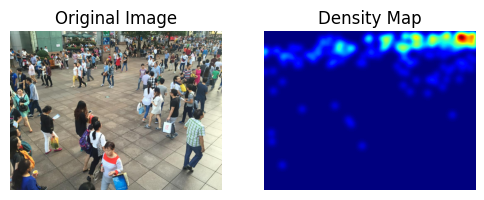

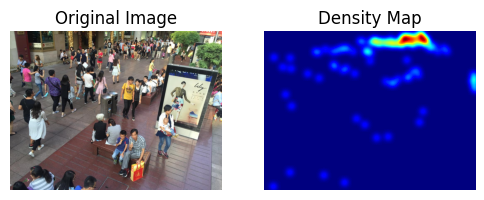

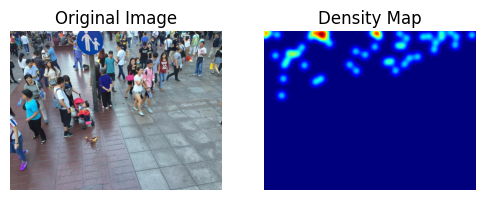

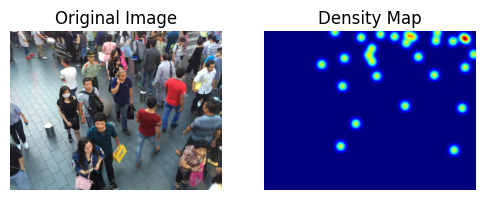

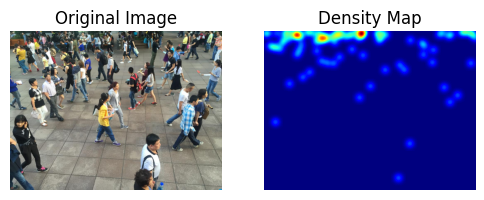

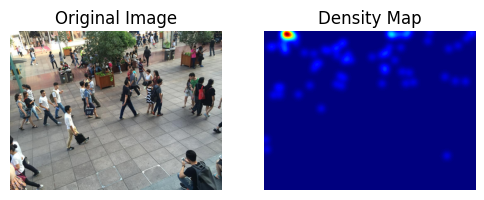

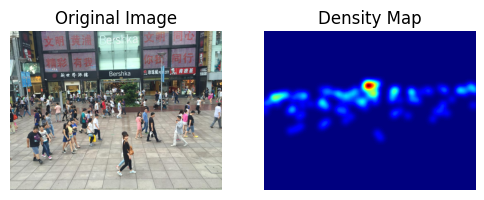

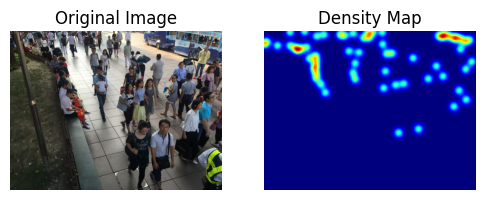

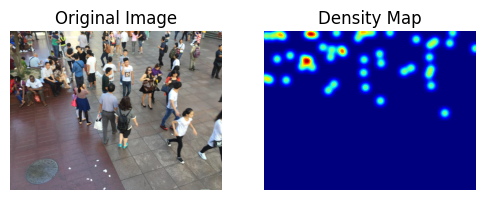

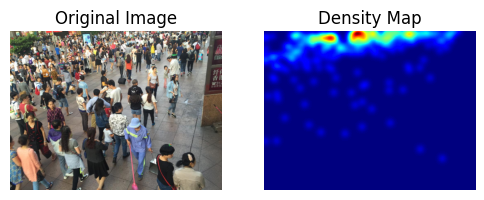

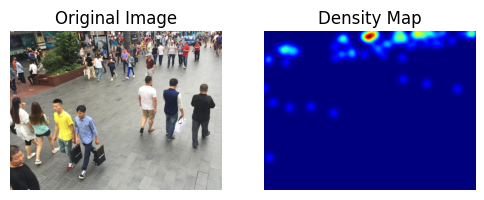

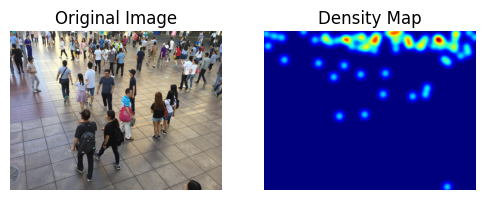

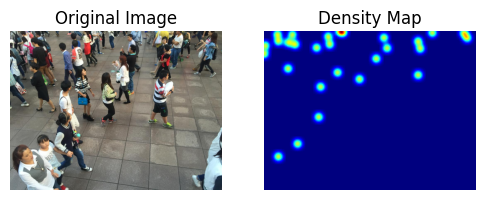

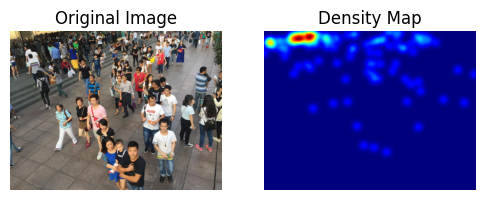

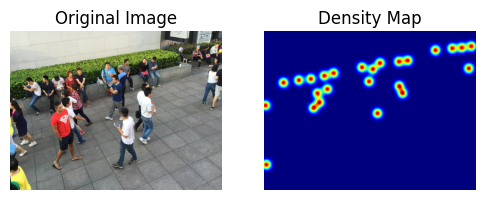

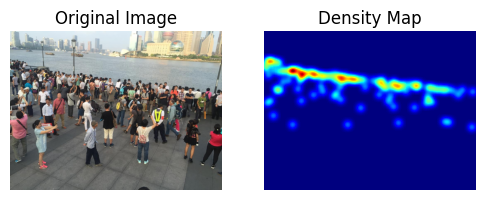

In [ ]:
import matplotlib.pyplot as plt

# Get one batch from the generator
images, density_maps = train_gen[0]
for i in range(len(images)):
    plt.figure(figsize=(6, 4))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(images[i].astype('uint8'))
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(density_maps[i].squeeze(), cmap='jet')
    plt.title('Density Map')
    plt.axis('off')

    plt.show()

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.utils import Sequence
import os

def gaussian_kernel(size: int, sigma: float):
    coords = tf.range(size, dtype=tf.float32) - size // 2
    g = tf.exp(-(coords ** 2) / (2. * sigma ** 2))
    g = g / tf.reduce_sum(g)
    return tf.tensordot(g, g, axes=0)

def ssim_loss(y_true, y_pred, window_size=11, C1=0.01**2, C2=0.03**2):
    kernel = gaussian_kernel(window_size, 1.5)
    kernel = kernel[:, :, tf.newaxis, tf.newaxis]

    mu1 = tf.nn.conv2d(y_true, kernel, strides=[1, 1, 1, 1], padding='SAME')
    mu2 = tf.nn.conv2d(y_pred, kernel, strides=[1, 1, 1, 1], padding='SAME')

    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2

    sigma1_sq = tf.nn.conv2d(y_true ** 2, kernel, strides=[1, 1, 1, 1], padding='SAME') - mu1_sq
    sigma2_sq = tf.nn.conv2d(y_pred ** 2, kernel, strides=[1, 1, 1, 1], padding='SAME') - mu2_sq
    sigma12 = tf.nn.conv2d(y_true * y_pred, kernel, strides=[1, 1, 1, 1], padding='SAME') - mu1_mu2

    ssim_map = ((2. * mu1_mu2 + C1) * (2. * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))
    return 1 - tf.reduce_mean(ssim_map)

def mssim_loss(y_true, y_pred):
    levels = 5
    weights = [0.0448, 0.2856, 0.3001, 0.2363, 0.1333]
    mssim = 0.0

    for i in range(levels):
        mssim += weights[i] * (1 - ssim_loss(y_true, y_pred))
        if i < levels - 1:
            y_true = tf.nn.avg_pool2d(y_true, ksize=2, strides=2, padding='SAME')
            y_pred = tf.nn.avg_pool2d(y_pred, ksize=2, strides=2, padding='SAME')

    return 1.0 - mssim

def mae_metric(y_true, y_pred):
    true_count = tf.reduce_sum(y_true, axis=[1, 2, 3])
    pred_count = tf.reduce_sum(y_pred, axis=[1, 2, 3])
    return tf.reduce_mean(tf.abs(true_count - pred_count))


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


def inverse_attention_block(input_tensor):
    attention_map = layers.Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid', padding='same')(input_tensor)
    inverse_map = 1 - attention_map
    return layers.multiply([input_tensor, inverse_map])

def residual_block(input_tensor):
    x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(input_tensor)
    x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same')(x)
    x = layers.add([x, input_tensor])
    x = layers.ReLU()(x)
    return x


def build_the_beast(input_shape=(768, 1024, 3)):
    """
    This function builds our multi-column, multi-scale, attention-packed,
    residual-block-rocking crowd counting model. LET'S GO!
    """
    inputs = keras.Input(shape=input_shape)
    img_height, img_width = input_shape[0], input_shape[1]

    scale_0_5x = layers.Resizing(img_height // 2, img_width // 2)(inputs)
    col1 = layers.Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu')(scale_0_5x)
    col1 = inverse_attention_block(col1)
    col1 = layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(col1)
    col1_out = layers.Resizing(img_height, img_width)(col1) 
    scale_1_0x = inputs
    col2 = layers.Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu')(scale_1_0x)
    col2 = inverse_attention_block(col2)
    col2 = layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(col2)
    col2_out = col2 
    scale_1_5x = layers.Resizing(int(img_height * 1.5), int(img_width * 1.5))(inputs) +
    col3 = layers.Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu')(scale_1_5x)
    col3 = inverse_attention_block(col3)
    col3 = layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(col3)
    col3_out = layers.Resizing(img_height, img_width)(col3) 

    fusion = layers.concatenate([col1_out, col2_out, col3_out], axis=-1)

    fusion = layers.Conv2D(filters=64, kernel_size=(1, 1), padding='same', activation='relu')(fusion)
    
    final_block = residual_block(fusion)
    
    output = layers.Conv2D(filters=1, kernel_size=(1, 1), activation='relu', padding='same')(final_block)
    
    model = keras.Model(inputs=inputs, outputs=output, name="Triple_Column_Trouble_Maker_V2")
    
    return model
model = build_the_beast()
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "Triple_Column_Trouble_Maker_V2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 768, 1024, 3)   │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resizing (Resizing)       │ (None, 384, 512, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resizing_2 (Resizing)     │ (None, 1152, 1536, 3)  │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 384, 512, 32)   │          2,432 │ resizing[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 1152, 1536, 32) │          2,432 │ resizing_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 384, 512, 1)    │             33 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 768, 1024, 32)  │          2,432 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 1152, 1536, 1)  │             33 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ subtract (Subtract)       │ (None, 384, 512, 1)    │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 768, 1024, 1)   │             33 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ subtract_2 (Subtract)     │ (None, 1152, 1536, 1)  │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 384, 512, 32)   │              0 │ conv2d[0][0],          │
│                           │                        │                │ subtract[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ subtract_1 (Subtract)     │ (None, 768, 1024, 1)   │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_2 (Multiply)     │ (None, 1152, 1536, 32) │              0 │ conv2d_6[0][0],        │
│                           │                        │                │ subtract_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 384, 512, 64)   │         18,496 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 768, 1024, 32)  │              0 │ conv2d_3[0][0],        │
│                           │                        │                │ subtract_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 1152, 1536, 64) │         18,496 │ multiply_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resizing_1 (Resizing)     │ (None, 768, 1024, 64)  │              0 │ conv2d_2[0][0]         │
├──────────────────────

 Total params: 149,156 (582.64 KB)

 Trainable params: 149,156 (582.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Save best model during training
checkpoint = ModelCheckpoint(
    'best_model_mssim.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=[checkpoint],
    verbose=1
)

# Print Final Validation MAE
val_mae_key = [k for k in history.history if 'val_mae' in k or 'val_mae_metric' in k]
if val_mae_key:
    final_val_mae = history.history[val_mae_key[0]][-1]
    print(f"\nFinal Validation MAE: {final_val_mae:.4f}")
else:
    print("MAE metric not found in training history.")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
